In [11]:
import os
import logging

import numpy as np
import imageio.v2 as imageio
import matplotlib
from matplotlib import pyplot as plt

import morphsnakes as ms



In [2]:
# in case you are running on machine without display, e.g. server
# if os.environ.get('DISPLAY', '') == '':
#     logging.warning('No display found. Using non-interactive Agg backend.')
#     matplotlib.use('Agg')

PATH_IMG_NODULE = 'images/mama07ORI.bmp'
PATH_IMG_STARFISH = 'images/seastar2.png'
PATH_IMG_LAKES = 'images/lakes3.jpg'
PATH_IMG_CAMERA = 'images/camera.png'
PATH_IMG_COINS = 'images/coins.png'
PATH_ARRAY_CONFOCAL = 'images/confocal.npy'

def rgb2gray(img):
    """Convert a RGB image to gray scale."""
    return 0.2989 * img[..., 0] + 0.587 * img[..., 1] + 0.114 * img[..., 2]


def visual_callback_2d(background, fig=None):
    """
    Returns a callback than can be passed as the argument `iter_callback`
    of `morphological_geodesic_active_contour` and
    `morphological_chan_vese` for visualizing the evolution
    of the levelsets. Only works for 2D images.

    Parameters
    ----------
    background : (M, N) array
        Image to be plotted as the background of the visual evolution.
    fig : matplotlib.figure.Figure
        Figure where results will be drawn. If not given, a new figure
        will be created.

    Returns
    -------
    callback : Python function
        A function that receives a levelset and updates the current plot
        accordingly. This can be passed as the `iter_callback` argument of
        `morphological_geodesic_active_contour` and
        `morphological_chan_vese`.

    """

    # Prepare the visual environment.
    if fig is None:
        fig = plt.figure()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(background, cmap=plt.cm.gray)

    ax2 = fig.add_subplot(1, 2, 2)
    ax_u = ax2.imshow(np.zeros_like(background), vmin=0, vmax=1)
    plt.pause(0.001)

    def callback(levelset):

        if ax1.collections:
            del ax1.collections[0]
        ax1.contour(levelset, [0.5], colors='r')
        ax_u.set_data(levelset)
        fig.canvas.draw()
        plt.pause(0.001)

    return callback


def visual_callback_3d(fig=None, plot_each=1):
    """
    Returns a callback than can be passed as the argument `iter_callback`
    of `morphological_geodesic_active_contour` and
    `morphological_chan_vese` for visualizing the evolution
    of the levelsets. Only works for 3D images.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure where results will be drawn. If not given, a new figure
        will be created.
    plot_each : positive integer
        The plot will be updated once every `plot_each` calls to the callback
        function.

    Returns
    -------
    callback : Python function
        A function that receives a levelset and updates the current plot
        accordingly. This can be passed as the `iter_callback` argument of
        `morphological_geodesic_active_contour` and
        `morphological_chan_vese`.

    """

    from mpl_toolkits.mplot3d import Axes3D
    # PyMCubes package is required for `visual_callback_3d`
    try:
        import mcubes
    except ImportError:
        raise ImportError("PyMCubes is required for 3D `visual_callback_3d`")

    # Prepare the visual environment.
    if fig is None:
        fig = plt.figure()
    fig.clf()
    ax = fig.add_subplot(111, projection='3d')
    plt.pause(0.001)

    counter = [-1]

    def callback(levelset):

        counter[0] += 1
        if (counter[0] % plot_each) != 0:
            return

        if ax.collections:
            del ax.collections[0]

        coords, triangles = mcubes.marching_cubes(levelset, 0.5)
        ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                        triangles=triangles)
        plt.pause(0.1)

    return callback


In [15]:
def example_nodule():
    logging.info('Running: example_nodule (MorphGAC)...')

    # Load the image.
    img = imread(PATH_IMG_NODULE)[..., 0] / 255.0

    # g(I)
    gimg = ms.inverse_gaussian_gradient(img, alpha=1000, sigma=5.48)

    # Initialization of the level-set.
    init_ls = ms.circle_level_set(img.shape, (100, 126), 20)

    # Callback for visual plotting
    callback = visual_callback_2d(img)

    # MorphGAC.
    ms.morphological_geodesic_active_contour(gimg, iterations=45,
                                             init_level_set=init_ls,
                                             smoothing=1, threshold=0.31,
                                             balloon=1, iter_callback=callback)


def example_starfish():
    logging.info('Running: example_starfish (MorphGAC)...')

    # Load the image.
    imgcolor = imread(PATH_IMG_STARFISH) / 255.0
    img = rgb2gray(imgcolor)

    # g(I)
    gimg = ms.inverse_gaussian_gradient(img, alpha=1000, sigma=2)

    # Initialization of the level-set.
    init_ls = ms.circle_level_set(img.shape, (163, 137), 135)

    # Callback for visual plotting
    callback = visual_callback_2d(imgcolor)

    # MorphGAC.
    ms.morphological_geodesic_active_contour(gimg, iterations=100,
                                             init_level_set=init_ls,
                                             smoothing=2, threshold=0.3,
                                             balloon=-1, iter_callback=callback)


def example_coins():
    logging.info('Running: example_coins (MorphGAC)...')

    # Load the image.
    img = imread(PATH_IMG_COINS) / 255.0

    # g(I)
    gimg = ms.inverse_gaussian_gradient(img)

    # Manual initialization of the level set
    init_ls = np.zeros(img.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1

    # Callback for visual plotting
    callback = visual_callback_2d(img)

    # MorphGAC.
    ms.morphological_geodesic_active_contour(gimg, 230, init_ls,
                                             smoothing=1, threshold=0.69,
                                             balloon=-1, iter_callback=callback)


def example_lakes():
    logging.info('Running: example_lakes (MorphACWE)...')

    # Load the image.
    imgcolor = imread(PATH_IMG_LAKES)/255.0
    img = rgb2gray(imgcolor)

    # MorphACWE does not need g(I)

    # Initialization of the level-set.
    init_ls = ms.circle_level_set(img.shape, (80, 170), 25)

    # Callback for visual plotting
    callback = visual_callback_2d(imgcolor)

    # Morphological Chan-Vese (or ACWE)
    ms.morphological_chan_vese(img, iterations=200,
                               init_level_set=init_ls,
                               smoothing=3, lambda1=1, lambda2=1,
                               iter_callback=callback)


def example_camera():
    """
    Example with `morphological_chan_vese` with using the default
    initialization of the level-set.
    """

    logging.info('Running: example_camera (MorphACWE)...')

    # Load the image.
    img = imread(PATH_IMG_CAMERA)/255.0

    # Callback for visual plotting
    callback = visual_callback_2d(img)

    # Morphological Chan-Vese (or ACWE)
    ms.morphological_chan_vese(img, 35,
                               smoothing=3, lambda1=1, lambda2=1,
                               iter_callback=callback)


def example_confocal3d():
    logging.info('Running: example_confocal3d (MorphACWE)...')

    # Load the image.
    img = np.load(PATH_ARRAY_CONFOCAL)

    # Initialization of the level-set.
    init_ls = ms.circle_level_set(img.shape, (30, 50, 80), 25)

    # Callback for visual plotting
    callback = visual_callback_3d(plot_each=20)

    # Morphological Chan-Vese (or ACWE)
    ms.morphological_chan_vese(img, iterations=150,
                               init_level_set=init_ls,
                               smoothing=1, lambda1=1, lambda2=2,
                               iter_callback=callback)

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2223498175.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(PATH_IMG_NODULE)[..., 0] / 255.0


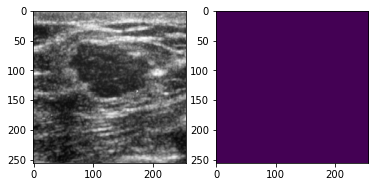

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2077076381.py:57: MatplotlibDeprecationWarning: 
The modification of the Axes.collections property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax1.collections[0]
C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2223498175.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgcolor = imread(PATH_IMG_STARFISH) / 255.0


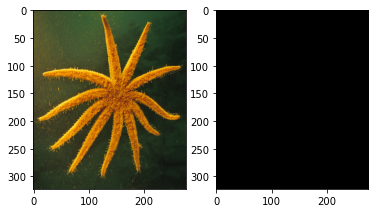

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2223498175.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(PATH_IMG_COINS) / 255.0


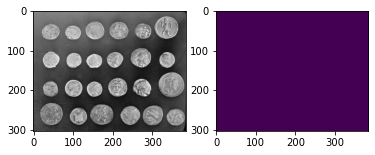

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2223498175.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgcolor = imread(PATH_IMG_LAKES)/255.0


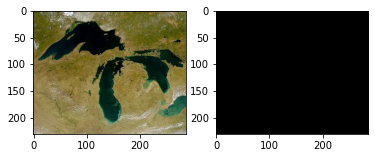

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2223498175.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(PATH_IMG_CAMERA)/255.0


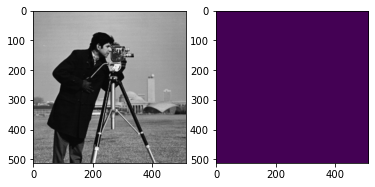

In [20]:
if __name__ == '__main__':
    logging.basicConfig(level=logging.DEBUG)
    example_nodule()
    example_starfish()
    example_coins()
    example_lakes()
    example_camera()

    # Uncomment the following line to see a 3D example
    # This is skipped by default since mplot3d is VERY slow plotting 3d meshes
    # example_confocal3d()

    logging.info("Done.")
    plt.show()


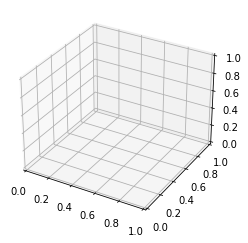

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_28552\2077076381.py:115: MatplotlibDeprecationWarning: 
The modification of the Axes.collections property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax.collections[0]


In [21]:
example_confocal3d()
plt.show()